In [43]:
import numpy as np
from cooperpairbox import Hcpb
import matplotlib.pyplot as plt
import lmfit as lm

In [44]:
def bootstrap(func, data, N=100):
    data = np.array(data)
    strapped = []    
    for i in range(N):
        if len(data.shape)>1:
            # take these in pairs of [f01, anharm]
            # don't mix and match
            new_choice = np.random.choice(len(data), len(data))
            new_sample = [data[i, :] for i in new_choice]
        else:
            new_sample = np.random.choice(data, data.shape)
        strapped.append(func(new_sample))
    return np.array(strapped)

def run_bootstrap(new_sample):
    cpb = Hcpb(nlevels=18)
    Ejs = []
    Ecs = []
    for sample in new_sample:
        Ej, Ec = cpb.params_from_spectrum(sample[0], sample[1])
        Ejs.append(Ej)
        Ecs.append(Ec)
    return [np.mean(Ejs), np.mean(Ecs)]



In [45]:
# Instantiate the cooperpairbox class
cpb = Hcpb(nlevels=50)
# Once Ej and Ec exist it can calculate any properties
# Can dynamically assign an Ej and Ec value
EjEc = 60.17532
Ec = 0.212346
cpb.Ej = EjEc*Ec
cpb.Ec = Ec
print(EjEc*Ec)
print(Ec)
# After both have been assigned it will automatically calculate any property asked for
# that is implemented in the methods
print(cpb.fij(0,1))
print(cpb.anharm())

f01 = cpb.fij(0,1)
anharm = cpb.anharm()

12.777988500720001
0.212346
4.435636212756457
-0.24020983814068408


In [46]:
# can also go the other way
# if you supply a spectrum it will perform an optimization to find
# the Ej and Ec that results in f01 and anharm (up to numerical accuracy)

#Instantiate a completely new instance of the class
cpb_new = Hcpb(nlevels=25)
res = cpb_new.params_from_spectrum(f01, anharm)
print(res)
print("Difference in value from the ideal")
print(np.abs(res[0]-EjEc*Ec), np.abs(res[1]-Ec))


(12.77798850072002, 0.21234599999999965)
Difference in value from the ideal
1.9539925233402755e-14 3.608224830031759e-16


In [47]:
# print the verbose version

res = cpb_new.params_from_spectrum(f01, anharm, verbose=True)
print(lm.report_fit(res))

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 16
    # data points      = 2
    # variables        = 2
    chi-square         = 7.8886e-31
    reduced chi-square = 7.8886e-31
    Akaike info crit   = -136.015730
    Bayesian info crit = -138.629436
[[Variables]]
    Ej:  12.7779885 +/- 5.8939e-15 (0.00%) (init = 11.37731)
    Ec:  0.21234600 +/- 6.8956e-17 (0.00%) (init = 0.2402098)
[[Correlations]] (unreported correlations are < 0.100)
    C(Ej, Ec) = -0.570
None


In [48]:
# Given an array of f01 and anharmonicities
# Commpute the bootstrap distribution of the distribution

# Let's assume we have identical qubits with some guassian noise
# equal to 5% of the mean value
# Doesn't need to be Gaussian can be anything

# This should be the empirical distribution extracted from the 32 identical
# transmons
f01 = 4.0 + np.random.normal(0, 0.05*4.0, 32)
anharm = -0.230 + np.random.normal(0, 0.05*0.23, 32)
print(f01[0], anharm[0])

# Stack these together. This should be the shape of the input data

spec_data = np.stack((f01, anharm), axis=1)
print(spec_data.shape)
print(len(spec_data))
print(spec_data[0, :])





3.5962800496668095 -0.22613979371682788
(32, 2)
32
[ 3.59628005 -0.22613979]


In [49]:
# From the original data of 32 identical qubits

# 1 - Resample the f01 and anharmonicities of those qubits
#     up to a sample size of 32
# 2 - For each of the new pairs of (f01, anharm) determine
#     the Ej and Ec from the spectrum
# 3 - Compute the mean(Ej) and mean(Ec) and append this to a list
# 4 - Repeat this N times

# 5 - This resampling tells you how mean(Ej) and mean(Ec) can vary
#     given the observed original 32 qubits

boot_data = bootstrap(run_bootstrap, spec_data, N=1000)

(1000, 2)


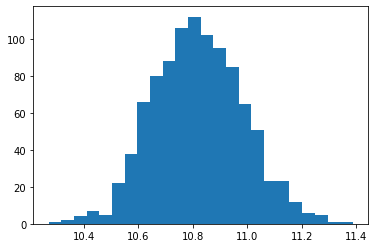

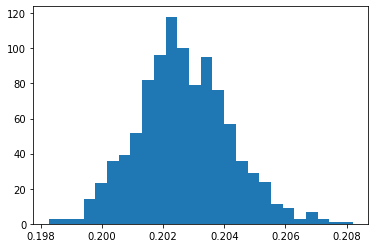

In [50]:
print(boot_data.shape)
plt.hist(boot_data[:, 0], bins='auto')
plt.show()
plt.hist(boot_data[:, 1], bins='auto')
plt.show()